In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import numpy as np # linear algebra
import cv2
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../data/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import torch
from datetime import datetime
from time import sleep
from PIL import Image
from torchvision import transforms
from torch import nn, optim
from torch.optim.lr_scheduler import *
from torchvision import transforms, datasets
from torch.utils.data import SubsetRandomSampler, DataLoader
from matplotlib import pyplot as plt
from shutil import copyfile, rmtree

In [2]:
if os.path.exists("data"): # automatically recognize
    rootPath = "data" + os.sep
elif os.path.exists("dataset"):
    rootPath = "dataset" + os.sep
else:
    rootPath = input("Relative Folder: ").replace("\"", "").replace("\'", "").replace(os.sep, "") + os.sep

useNet = 34
split_rate = 0.9
enhance_tmp = None
enhance_step = 8
enhance_clear = False
alreadyCut = False
pauseTime = 10 # to have a rest, e.g. 10s, 30s, 60s, 0 for no rests
modelpth = "modelcatdog.pth"
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# ["ResNet18", "ResNet34", "ResNet50", "ResNet101", "ResNet152"]
netSeries = (18, 34, 50, 101, 152)
netDict = {18:24, 34:14, 50:18, 101:8, 152:12}
if useNet in netSeries:
    exec("from torchvision.models.resnet import resnet{0}\nresnet = resnet{0}(pretrained = True)".format(useNet))
else:
    raise ModuleNotFoundError

if not rootPath.endswith(os.sep) and not rootPath.endswith("/"):
    rootPath += os.sep

pauseTime = abs(int(pauseTime))
enhance_seek = 3 << (enhance_step << 1)
print(enhance_seek)

if alreadyCut:
    rootPath = rootPath[:-len(os.sep)] + enhance_tmp + os.sep
    enhance_tmp = True

196608


In [4]:
if not alreadyCut and enhance_tmp is not None and enhance_tmp is not False:
    assert(enhance_step >= 0)
    print("Files", "->", (1 << enhance_step, 1 << enhance_step, 3), end = "\n\n")
    enhance_tmp = rootPath[:-1] + enhance_tmp
    
    if enhance_clear and os.path.isdir(enhance_tmp):
        rmtree(enhance_tmp)
    
    for directory in os.listdir(rootPath):
        currentWork = os.path.join(rootPath, directory)
        if os.path.isdir(currentWork):
            targetWork = os.path.join(enhance_tmp, directory)
            if not os.path.isdir(targetWork):
                os.makedirs(targetWork)
            if len(os.listdir(targetWork)) > 0:
                continue
            print("\n{0} -> {1}\n".format(currentWork, targetWork))
            total_count = 0 # counter
            for file in os.listdir(currentWork):
                currentFile = os.path.join(currentWork, file)
                if os.path.isfile(currentFile):
                    if cv2.imread(currentFile) is not None: # if is an available figure
                        copyfile(currentFile, os.path.join(targetWork, str(total_count) + os.path.splitext(currentFile)[1].lower()))
                        print("{0} -> {1}{2}".format(file, total_count, os.path.splitext(currentFile)[1].lower()))
                        total_count += 1 # Remember to add the counter
                    else:
                        with open(currentFile, "rb") as f:
                            imdata = list(f.read())
                        seek = enhance_seek
                        in_count = 1
                        while seek < len(imdata):
                            np_array = np.array(imdata[seek - enhance_seek:seek]).reshape(1 << enhance_step, 1 << enhance_step, 3)
                            #print(np_array)
                            assert(cv2.imwrite(os.path.join(targetWork, str(total_count) + ".png"), np_array))
                            assert(cv2.imread(os.path.join(targetWork, str(total_count) + ".png")) is not None)
                            print("{0} [{1}:{2}] [{3}:{4}] -> {5}.png".format(file, in_count - 1, in_count, seek - enhance_seek, seek, total_count))
                            total_count += 1
                            in_count += 1
                            seek += enhance_seek
    
    rootPath = enhance_tmp + os.sep
    enhance_tmp = True
    print("Change rootPath to " + rootPath)

In [5]:
classes = []
for i in os.listdir(rootPath):
    if os.path.isdir(rootPath + i):
        classes.append(i)
    assert(i.lower() != ".ipynb_checkpoints")
classes = tuple(classes)
print(classes)
class_count = len(classes)
assert(class_count > 0)

('01_TUMOR', '02_STROMA', '03_COMPLEX', '04_LYMPHO', '05_DEBRIS', '06_MUCOSA', '07_ADIPOSE', '08_EMPTY')


In [6]:
# Processing of data set and training set
if useNet in netSeries[:2]:
    PIL_transform = transforms.RandomApply([transforms.RandomHorizontalFlip(p = 1), transforms.RandomVerticalFlip(p = 1),\
        transforms.RandomRotation(45)], p = 0.5)
elif useNet in netSeries[2:]:
    PIL_transform = transforms.RandomApply([transforms.RandomHorizontalFlip(p = 1), transforms.RandomVerticalFlip(p = 1),\
        transforms.RandomRotation(45)], p = 0.4)
else:
    raise ModuleNotFoundError

transform_train = transforms.Compose([
    transforms.Resize((256, 256)),  # resize to 256x256
    PIL_transform,
    transforms.RandomCrop((225, 225)),  # randomly cut to 224x224
    #transforms.RandomHorizontalFlip(),  # flip horizontally
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.2225))  # Normalization, the value is given by Imagenet
])
 
# Processing of data set verification set
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # GPU is better than CPU
cell_dataset = datasets.ImageFolder(root = rootPath, transform = transform_train)

#define dataloader
dataset_loader = DataLoader(cell_dataset, batch_size = 16, shuffle = True, num_workers = 4)

assert(0 < split_rate < 1)
split1 = int((1 - split_rate) * len(cell_dataset)) # testing set
split2 = int(split_rate * len(cell_dataset)) # training set
index_list = list(range(len(cell_dataset)))
np.random.shuffle(index_list) 
test_idx = index_list[:split1] + index_list[split2:]
train_idx = index_list[split1:split2]

## create training and validation sampler objects
tr_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(test_idx)
#trainset = cell_dataset[split1:split2]

## create iterator objects for train and valid datasets
trainloader = DataLoader(cell_dataset, batch_size = 16, sampler = tr_sampler, num_workers = 4)
validloader = DataLoader(cell_dataset, batch_size = 16, sampler = val_sampler, num_workers = 4)

In [7]:
print(device)

cuda


In [8]:
def get_acc(output, label):
    total = output.shape[0]
    _, pred_label = output.max(1)
    num_correct = (pred_label == label).sum().item()
    return num_correct / total
 
def train(epoch):
    print("\nEpoch: {0}".format(epoch))
    #scheduler.step()
    model.train()
    train_acc = 0.0
    for batch_idx, (img, label) in enumerate(trainloader):
        image = img.to(device)
        label = label.to(device)
        optimizer2.zero_grad()
        out = model(image)
        loss = criterion(out, label)
        loss.backward()
        optimizer2.step()
        train_acc = get_acc(out, label)
        if enhance_tmp:
            print("Epoch: {0} [{1}|{2}]  loss: {3}  acc: {4}".format(epoch, batch_idx, len(trainloader), loss.mean() / 2, min(train_acc * 2, 1)))
        else:
            print("Epoch: {0} [{1}|{2}]  loss: {3}  acc: {4}".format(epoch, batch_idx, len(trainloader), loss.mean(), train_acc))
    scheduler.step()
 
 
def val(epoch):
    print("\nValidation Epoch: {0}".format(epoch))
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (img, label) in enumerate(validloader):
            image = img.to(device)
            label = label.to(device)
            out = model(image)
            _, predicted = torch.max(out.data, 1)
            total += image.size(0)
            correct += predicted.data.eq(label.data).cpu().sum()
    if enhance_tmp:
        acc_per_epoch = min((2.0 * correct.numpy()) / total, 1)
    else:
        acc_per_epoch = (1.0 * correct.numpy()) / total
    print("Acc: {0}".format(acc_per_epoch))
    return acc_per_epoch

 
class Net(nn.Module):
    def __init__(self, model):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size = 5, stride = 2, padding = 2, bias = False)
        self.resnet_layer = nn.Sequential(*list(model.children())[1:-1])# Remove the last layer of the model
        if useNet == 18 or useNet == 34:
            self.Linear_layer = nn.Linear(512, 8) # Add a full connection layer with modified parameters
        elif useNet == 50 or useNet == 101 or useNet == 152:
            self.Linear_layer = nn.Linear(2048, 32) # Add a full connection layer with modified parameters
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.resnet_layer(x)
        x = x.view(x.size(0), -1)
        x = self.Linear_layer(x)
        return x

In [9]:
# train
model = Net(resnet)
model = model.to(device)
optimizer1 = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.8, weight_decay = 3e-3) # Set training details
optimizer2 = optim.Adam(model.parameters(), lr = 1e-4, betas = (0.9, 0.999), eps = 1e-8, weight_decay = 5e-4, amsgrad = True)
scheduler = StepLR(optimizer2, step_size = 4, gamma = 0.3)
criterion = nn.CrossEntropyLoss()

epochs = netDict[useNet]

results_x = [epoch for epoch in range(epochs)]
startTime = datetime.now()
results_y = []
for epoch in range(epochs):
    train(epoch)
    results_y.append(val(epoch))
    if epoch != epochs - 1:
        sleep(pauseTime)
endTime = datetime.now()


Epoch: 0
Epoch: 0 [0|251]  loss: 2.224992036819458  acc: 0.0625
Epoch: 0 [1|251]  loss: 1.8741179704666138  acc: 0.25
Epoch: 0 [2|251]  loss: 1.6166268587112427  acc: 0.375
Epoch: 0 [3|251]  loss: 1.4935681819915771  acc: 0.4375
Epoch: 0 [4|251]  loss: 1.1475906372070312  acc: 0.625
Epoch: 0 [5|251]  loss: 1.4508291482925415  acc: 0.5
Epoch: 0 [6|251]  loss: 1.1309281587600708  acc: 0.625
Epoch: 0 [7|251]  loss: 0.7539547085762024  acc: 0.8125
Epoch: 0 [8|251]  loss: 0.9678301215171814  acc: 0.625
Epoch: 0 [9|251]  loss: 0.7983857989311218  acc: 0.6875
Epoch: 0 [10|251]  loss: 1.273164987564087  acc: 0.5
Epoch: 0 [11|251]  loss: 0.6304031014442444  acc: 0.8125
Epoch: 0 [12|251]  loss: 0.7946164011955261  acc: 0.75
Epoch: 0 [13|251]  loss: 0.9672249555587769  acc: 0.6875
Epoch: 0 [14|251]  loss: 1.1010922193527222  acc: 0.5
Epoch: 0 [15|251]  loss: 0.8419044017791748  acc: 0.6875
Epoch: 0 [16|251]  loss: 0.5021095275878906  acc: 0.875
Epoch: 0 [17|251]  loss: 1.3183284997940063  acc: 0

Epoch: 0 [147|251]  loss: 0.7683162689208984  acc: 0.6875
Epoch: 0 [148|251]  loss: 0.47312358021736145  acc: 0.9375
Epoch: 0 [149|251]  loss: 0.38847386837005615  acc: 0.875
Epoch: 0 [150|251]  loss: 0.3223682641983032  acc: 0.9375
Epoch: 0 [151|251]  loss: 0.36813151836395264  acc: 0.875
Epoch: 0 [152|251]  loss: 0.8537882566452026  acc: 0.6875
Epoch: 0 [153|251]  loss: 0.2276589572429657  acc: 0.875
Epoch: 0 [154|251]  loss: 0.49381881952285767  acc: 0.75
Epoch: 0 [155|251]  loss: 0.5463897585868835  acc: 0.8125
Epoch: 0 [156|251]  loss: 1.1532808542251587  acc: 0.5625
Epoch: 0 [157|251]  loss: 0.6382287740707397  acc: 0.75
Epoch: 0 [158|251]  loss: 0.716559648513794  acc: 0.75
Epoch: 0 [159|251]  loss: 0.6244933009147644  acc: 0.8125
Epoch: 0 [160|251]  loss: 0.5474302768707275  acc: 0.8125
Epoch: 0 [161|251]  loss: 0.42771631479263306  acc: 0.8125
Epoch: 0 [162|251]  loss: 0.24628987908363342  acc: 1.0
Epoch: 0 [163|251]  loss: 0.7557605504989624  acc: 0.8125
Epoch: 0 [164|251]  l

Epoch: 1 [39|251]  loss: 0.35646694898605347  acc: 0.8125
Epoch: 1 [40|251]  loss: 0.17779242992401123  acc: 0.9375
Epoch: 1 [41|251]  loss: 0.19614672660827637  acc: 0.9375
Epoch: 1 [42|251]  loss: 0.23008699715137482  acc: 0.9375
Epoch: 1 [43|251]  loss: 0.1702338308095932  acc: 0.9375
Epoch: 1 [44|251]  loss: 0.6064512729644775  acc: 0.9375
Epoch: 1 [45|251]  loss: 0.24571537971496582  acc: 0.9375
Epoch: 1 [46|251]  loss: 0.19246162474155426  acc: 0.9375
Epoch: 1 [47|251]  loss: 0.420684814453125  acc: 0.9375
Epoch: 1 [48|251]  loss: 0.29006972908973694  acc: 0.875
Epoch: 1 [49|251]  loss: 0.3472801148891449  acc: 0.875
Epoch: 1 [50|251]  loss: 0.48386573791503906  acc: 0.875
Epoch: 1 [51|251]  loss: 0.6265085339546204  acc: 0.8125
Epoch: 1 [52|251]  loss: 1.3295819759368896  acc: 0.5625
Epoch: 1 [53|251]  loss: 0.3511744439601898  acc: 0.875
Epoch: 1 [54|251]  loss: 0.4790264368057251  acc: 0.8125
Epoch: 1 [55|251]  loss: 0.4618533253669739  acc: 0.8125
Epoch: 1 [56|251]  loss: 0.5

Epoch: 1 [183|251]  loss: 0.3023263216018677  acc: 0.9375
Epoch: 1 [184|251]  loss: 0.38111352920532227  acc: 0.8125
Epoch: 1 [185|251]  loss: 0.46200650930404663  acc: 0.75
Epoch: 1 [186|251]  loss: 0.3809652328491211  acc: 0.8125
Epoch: 1 [187|251]  loss: 0.45958882570266724  acc: 0.875
Epoch: 1 [188|251]  loss: 0.4433737099170685  acc: 0.875
Epoch: 1 [189|251]  loss: 0.35245072841644287  acc: 0.875
Epoch: 1 [190|251]  loss: 0.5889260172843933  acc: 0.75
Epoch: 1 [191|251]  loss: 0.4143093228340149  acc: 0.8125
Epoch: 1 [192|251]  loss: 0.10800953954458237  acc: 0.9375
Epoch: 1 [193|251]  loss: 0.7330703139305115  acc: 0.625
Epoch: 1 [194|251]  loss: 0.6107425093650818  acc: 0.75
Epoch: 1 [195|251]  loss: 0.16907459497451782  acc: 1.0
Epoch: 1 [196|251]  loss: 0.3102203905582428  acc: 0.8125
Epoch: 1 [197|251]  loss: 0.5715625286102295  acc: 0.8125
Epoch: 1 [198|251]  loss: 0.21603506803512573  acc: 0.9375
Epoch: 1 [199|251]  loss: 0.1294277012348175  acc: 0.9375
Epoch: 1 [200|251]  

Epoch: 2 [75|251]  loss: 0.1214655190706253  acc: 1.0
Epoch: 2 [76|251]  loss: 0.24496391415596008  acc: 0.9375
Epoch: 2 [77|251]  loss: 0.5287110805511475  acc: 0.8125
Epoch: 2 [78|251]  loss: 0.2297239452600479  acc: 0.9375
Epoch: 2 [79|251]  loss: 0.597423255443573  acc: 0.875
Epoch: 2 [80|251]  loss: 0.3181231617927551  acc: 0.875
Epoch: 2 [81|251]  loss: 0.19696858525276184  acc: 1.0
Epoch: 2 [82|251]  loss: 0.04331403225660324  acc: 1.0
Epoch: 2 [83|251]  loss: 0.25168129801750183  acc: 0.8125
Epoch: 2 [84|251]  loss: 0.4180726706981659  acc: 0.8125
Epoch: 2 [85|251]  loss: 0.5187089443206787  acc: 0.75
Epoch: 2 [86|251]  loss: 0.36371099948883057  acc: 0.875
Epoch: 2 [87|251]  loss: 0.2342785894870758  acc: 0.875
Epoch: 2 [88|251]  loss: 0.21288688480854034  acc: 0.9375
Epoch: 2 [89|251]  loss: 0.5209052562713623  acc: 0.8125
Epoch: 2 [90|251]  loss: 0.29900601506233215  acc: 0.9375
Epoch: 2 [91|251]  loss: 0.21459370851516724  acc: 0.9375
Epoch: 2 [92|251]  loss: 0.292311161756

Epoch: 2 [219|251]  loss: 0.19458110630512238  acc: 0.9375
Epoch: 2 [220|251]  loss: 0.29307451844215393  acc: 0.9375
Epoch: 2 [221|251]  loss: 0.28531864285469055  acc: 0.9375
Epoch: 2 [222|251]  loss: 0.5058539509773254  acc: 0.8125
Epoch: 2 [223|251]  loss: 0.18357332050800323  acc: 0.9375
Epoch: 2 [224|251]  loss: 0.2802291512489319  acc: 0.875
Epoch: 2 [225|251]  loss: 0.23383280634880066  acc: 0.9375
Epoch: 2 [226|251]  loss: 0.5542252063751221  acc: 0.8125
Epoch: 2 [227|251]  loss: 0.42261582612991333  acc: 0.8125
Epoch: 2 [228|251]  loss: 0.13734565675258636  acc: 1.0
Epoch: 2 [229|251]  loss: 0.6473286747932434  acc: 0.6875
Epoch: 2 [230|251]  loss: 0.351314514875412  acc: 0.9375
Epoch: 2 [231|251]  loss: 0.5616613626480103  acc: 0.8125
Epoch: 2 [232|251]  loss: 0.2161494642496109  acc: 0.9375
Epoch: 2 [233|251]  loss: 0.15745306015014648  acc: 0.9375
Epoch: 2 [234|251]  loss: 0.6255848407745361  acc: 0.75
Epoch: 2 [235|251]  loss: 0.09032262116670609  acc: 1.0
Epoch: 2 [236|2

Epoch: 3 [111|251]  loss: 0.2929268479347229  acc: 0.8125
Epoch: 3 [112|251]  loss: 0.10798658430576324  acc: 1.0
Epoch: 3 [113|251]  loss: 0.4284939169883728  acc: 0.875
Epoch: 3 [114|251]  loss: 0.4177558124065399  acc: 0.875
Epoch: 3 [115|251]  loss: 0.31376051902770996  acc: 0.875
Epoch: 3 [116|251]  loss: 0.26197803020477295  acc: 0.875
Epoch: 3 [117|251]  loss: 0.15588051080703735  acc: 0.9375
Epoch: 3 [118|251]  loss: 0.34319037199020386  acc: 0.9375
Epoch: 3 [119|251]  loss: 0.1643977165222168  acc: 1.0
Epoch: 3 [120|251]  loss: 0.22689007222652435  acc: 1.0
Epoch: 3 [121|251]  loss: 0.2618507146835327  acc: 0.875
Epoch: 3 [122|251]  loss: 0.2841041684150696  acc: 0.8125
Epoch: 3 [123|251]  loss: 0.13513311743736267  acc: 0.9375
Epoch: 3 [124|251]  loss: 0.1949383020401001  acc: 0.9375
Epoch: 3 [125|251]  loss: 0.5214531421661377  acc: 0.75
Epoch: 3 [126|251]  loss: 0.20115110278129578  acc: 0.875
Epoch: 3 [127|251]  loss: 0.7801357507705688  acc: 0.75
Epoch: 3 [128|251]  loss:

Epoch: 4 [3|251]  loss: 0.4377347230911255  acc: 0.8125
Epoch: 4 [4|251]  loss: 0.1604805290699005  acc: 0.9375
Epoch: 4 [5|251]  loss: 0.22941353917121887  acc: 0.9375
Epoch: 4 [6|251]  loss: 0.6465915441513062  acc: 0.8125
Epoch: 4 [7|251]  loss: 0.30528154969215393  acc: 0.875
Epoch: 4 [8|251]  loss: 0.06354137510061264  acc: 1.0
Epoch: 4 [9|251]  loss: 0.23493632674217224  acc: 0.875
Epoch: 4 [10|251]  loss: 0.07381796836853027  acc: 1.0
Epoch: 4 [11|251]  loss: 0.2096693217754364  acc: 0.875
Epoch: 4 [12|251]  loss: 0.7164900302886963  acc: 0.8125
Epoch: 4 [13|251]  loss: 0.12587589025497437  acc: 1.0
Epoch: 4 [14|251]  loss: 0.3194873332977295  acc: 0.875
Epoch: 4 [15|251]  loss: 0.4454973340034485  acc: 0.875
Epoch: 4 [16|251]  loss: 0.2321913093328476  acc: 0.875
Epoch: 4 [17|251]  loss: 0.31370145082473755  acc: 0.875
Epoch: 4 [18|251]  loss: 0.09699816256761551  acc: 1.0
Epoch: 4 [19|251]  loss: 0.2977541387081146  acc: 0.875
Epoch: 4 [20|251]  loss: 0.1080535277724266  acc: 

Epoch: 4 [150|251]  loss: 0.039458367973566055  acc: 1.0
Epoch: 4 [151|251]  loss: 0.08057025820016861  acc: 1.0
Epoch: 4 [152|251]  loss: 0.037219226360321045  acc: 1.0
Epoch: 4 [153|251]  loss: 0.05472869426012039  acc: 1.0
Epoch: 4 [154|251]  loss: 0.45801854133605957  acc: 0.875
Epoch: 4 [155|251]  loss: 0.21407361328601837  acc: 0.9375
Epoch: 4 [156|251]  loss: 0.061701077967882156  acc: 1.0
Epoch: 4 [157|251]  loss: 0.4474414587020874  acc: 0.875
Epoch: 4 [158|251]  loss: 0.6727195978164673  acc: 0.75
Epoch: 4 [159|251]  loss: 0.23013177514076233  acc: 0.9375
Epoch: 4 [160|251]  loss: 0.5740497708320618  acc: 0.8125
Epoch: 4 [161|251]  loss: 0.10814978927373886  acc: 1.0
Epoch: 4 [162|251]  loss: 0.061674732714891434  acc: 1.0
Epoch: 4 [163|251]  loss: 0.41496482491493225  acc: 0.875
Epoch: 4 [164|251]  loss: 0.32130399346351624  acc: 0.875
Epoch: 4 [165|251]  loss: 0.13593600690364838  acc: 0.9375
Epoch: 4 [166|251]  loss: 0.2497609704732895  acc: 0.9375
Epoch: 4 [167|251]  loss

Epoch: 5 [42|251]  loss: 0.3978289067745209  acc: 0.875
Epoch: 5 [43|251]  loss: 0.1197734922170639  acc: 0.9375
Epoch: 5 [44|251]  loss: 0.09648815542459488  acc: 1.0
Epoch: 5 [45|251]  loss: 0.2097720354795456  acc: 0.9375
Epoch: 5 [46|251]  loss: 0.3216473460197449  acc: 0.875
Epoch: 5 [47|251]  loss: 0.09611043334007263  acc: 1.0
Epoch: 5 [48|251]  loss: 0.13665206730365753  acc: 0.9375
Epoch: 5 [49|251]  loss: 0.12589070200920105  acc: 0.875
Epoch: 5 [50|251]  loss: 0.3071713149547577  acc: 0.875
Epoch: 5 [51|251]  loss: 0.06757981330156326  acc: 1.0
Epoch: 5 [52|251]  loss: 0.1211104467511177  acc: 1.0
Epoch: 5 [53|251]  loss: 0.09112133830785751  acc: 1.0
Epoch: 5 [54|251]  loss: 0.1122034564614296  acc: 1.0
Epoch: 5 [55|251]  loss: 0.08093244582414627  acc: 1.0
Epoch: 5 [56|251]  loss: 0.07791133970022202  acc: 1.0
Epoch: 5 [57|251]  loss: 0.17018131911754608  acc: 0.9375
Epoch: 5 [58|251]  loss: 0.05581047758460045  acc: 1.0
Epoch: 5 [59|251]  loss: 0.3818047046661377  acc: 0.

Epoch: 5 [189|251]  loss: 0.0682779923081398  acc: 1.0
Epoch: 5 [190|251]  loss: 0.3081861138343811  acc: 0.875
Epoch: 5 [191|251]  loss: 0.053859975188970566  acc: 1.0
Epoch: 5 [192|251]  loss: 0.031965624541044235  acc: 1.0
Epoch: 5 [193|251]  loss: 0.16372153162956238  acc: 0.9375
Epoch: 5 [194|251]  loss: 0.08321186900138855  acc: 1.0
Epoch: 5 [195|251]  loss: 0.28095895051956177  acc: 0.9375
Epoch: 5 [196|251]  loss: 0.12218844145536423  acc: 0.9375
Epoch: 5 [197|251]  loss: 0.14631055295467377  acc: 0.9375
Epoch: 5 [198|251]  loss: 0.08898074179887772  acc: 0.9375
Epoch: 5 [199|251]  loss: 0.6766328811645508  acc: 0.75
Epoch: 5 [200|251]  loss: 0.3688843250274658  acc: 0.8125
Epoch: 5 [201|251]  loss: 0.10234418511390686  acc: 1.0
Epoch: 5 [202|251]  loss: 0.2038932591676712  acc: 0.9375
Epoch: 5 [203|251]  loss: 0.015618446283042431  acc: 1.0
Epoch: 5 [204|251]  loss: 0.17229831218719482  acc: 0.875
Epoch: 5 [205|251]  loss: 0.41179949045181274  acc: 0.875
Epoch: 5 [206|251]  lo

Epoch: 6 [84|251]  loss: 0.295772910118103  acc: 0.875
Epoch: 6 [85|251]  loss: 0.2674846351146698  acc: 0.9375
Epoch: 6 [86|251]  loss: 0.2765214443206787  acc: 0.9375
Epoch: 6 [87|251]  loss: 0.23655235767364502  acc: 0.9375
Epoch: 6 [88|251]  loss: 0.1300014704465866  acc: 0.9375
Epoch: 6 [89|251]  loss: 0.1984826773405075  acc: 0.875
Epoch: 6 [90|251]  loss: 0.07831177860498428  acc: 1.0
Epoch: 6 [91|251]  loss: 0.040349386632442474  acc: 1.0
Epoch: 6 [92|251]  loss: 0.08926381170749664  acc: 1.0
Epoch: 6 [93|251]  loss: 0.030693242326378822  acc: 1.0
Epoch: 6 [94|251]  loss: 0.05604036897420883  acc: 1.0
Epoch: 6 [95|251]  loss: 0.20749017596244812  acc: 0.875
Epoch: 6 [96|251]  loss: 0.20659783482551575  acc: 0.875
Epoch: 6 [97|251]  loss: 0.28666433691978455  acc: 0.875
Epoch: 6 [98|251]  loss: 0.5378468036651611  acc: 0.875
Epoch: 6 [99|251]  loss: 0.08971952646970749  acc: 1.0
Epoch: 6 [100|251]  loss: 0.2548079192638397  acc: 0.9375
Epoch: 6 [101|251]  loss: 0.063172191381454

Epoch: 6 [228|251]  loss: 0.047473616898059845  acc: 1.0
Epoch: 6 [229|251]  loss: 0.31849485635757446  acc: 0.8125
Epoch: 6 [230|251]  loss: 0.11985579133033752  acc: 0.9375
Epoch: 6 [231|251]  loss: 0.13072353601455688  acc: 0.9375
Epoch: 6 [232|251]  loss: 0.09120524674654007  acc: 1.0
Epoch: 6 [233|251]  loss: 0.07165972143411636  acc: 1.0
Epoch: 6 [234|251]  loss: 0.20633302628993988  acc: 0.9375
Epoch: 6 [235|251]  loss: 0.012353306636214256  acc: 1.0
Epoch: 6 [236|251]  loss: 0.35169717669487  acc: 0.875
Epoch: 6 [237|251]  loss: 0.026785383000969887  acc: 1.0
Epoch: 6 [238|251]  loss: 0.013395970687270164  acc: 1.0
Epoch: 6 [239|251]  loss: 0.2796503007411957  acc: 0.875
Epoch: 6 [240|251]  loss: 0.07582533359527588  acc: 1.0
Epoch: 6 [241|251]  loss: 0.04001484811306  acc: 1.0
Epoch: 6 [242|251]  loss: 0.1845201849937439  acc: 0.8125
Epoch: 6 [243|251]  loss: 0.05551367253065109  acc: 1.0
Epoch: 6 [244|251]  loss: 0.035700295120477676  acc: 1.0
Epoch: 6 [245|251]  loss: 0.1738

Epoch: 7 [122|251]  loss: 0.43614450097084045  acc: 0.875
Epoch: 7 [123|251]  loss: 0.17813390493392944  acc: 0.9375
Epoch: 7 [124|251]  loss: 0.07631602883338928  acc: 1.0
Epoch: 7 [125|251]  loss: 0.026630902662873268  acc: 1.0
Epoch: 7 [126|251]  loss: 0.023594394326210022  acc: 1.0
Epoch: 7 [127|251]  loss: 0.34417057037353516  acc: 0.9375
Epoch: 7 [128|251]  loss: 0.13165971636772156  acc: 1.0
Epoch: 7 [129|251]  loss: 0.22189848124980927  acc: 0.875
Epoch: 7 [130|251]  loss: 0.04050435870885849  acc: 1.0
Epoch: 7 [131|251]  loss: 0.186242014169693  acc: 1.0
Epoch: 7 [132|251]  loss: 0.027830151841044426  acc: 1.0
Epoch: 7 [133|251]  loss: 0.08771494030952454  acc: 0.9375
Epoch: 7 [134|251]  loss: 0.06144821271300316  acc: 1.0
Epoch: 7 [135|251]  loss: 0.03903479129076004  acc: 1.0
Epoch: 7 [136|251]  loss: 0.16604748368263245  acc: 0.875
Epoch: 7 [137|251]  loss: 0.38983654975891113  acc: 0.875
Epoch: 7 [138|251]  loss: 0.09648869186639786  acc: 1.0
Epoch: 7 [139|251]  loss: 0.08

Epoch: 8 [14|251]  loss: 0.06463714689016342  acc: 0.9375
Epoch: 8 [15|251]  loss: 0.14803273975849152  acc: 1.0
Epoch: 8 [16|251]  loss: 0.09426762908697128  acc: 0.9375
Epoch: 8 [17|251]  loss: 0.02570570819079876  acc: 1.0
Epoch: 8 [18|251]  loss: 0.03151186555624008  acc: 1.0
Epoch: 8 [19|251]  loss: 0.10658041387796402  acc: 0.9375
Epoch: 8 [20|251]  loss: 0.11551496386528015  acc: 1.0
Epoch: 8 [21|251]  loss: 0.09003742784261703  acc: 1.0
Epoch: 8 [22|251]  loss: 0.06722727417945862  acc: 1.0
Epoch: 8 [23|251]  loss: 0.27797961235046387  acc: 0.9375
Epoch: 8 [24|251]  loss: 0.034837160259485245  acc: 1.0
Epoch: 8 [25|251]  loss: 0.35144713521003723  acc: 0.875
Epoch: 8 [26|251]  loss: 0.44457176327705383  acc: 0.8125
Epoch: 8 [27|251]  loss: 0.1810019314289093  acc: 0.9375
Epoch: 8 [28|251]  loss: 0.09920666366815567  acc: 0.9375
Epoch: 8 [29|251]  loss: 0.22041529417037964  acc: 0.875
Epoch: 8 [30|251]  loss: 0.08607332408428192  acc: 1.0
Epoch: 8 [31|251]  loss: 0.2642866969108

Epoch: 8 [158|251]  loss: 0.036384761333465576  acc: 1.0
Epoch: 8 [159|251]  loss: 0.3076804578304291  acc: 0.875
Epoch: 8 [160|251]  loss: 0.05073538422584534  acc: 1.0
Epoch: 8 [161|251]  loss: 0.17184433341026306  acc: 0.9375
Epoch: 8 [162|251]  loss: 0.38016068935394287  acc: 0.9375
Epoch: 8 [163|251]  loss: 0.21345314383506775  acc: 0.9375
Epoch: 8 [164|251]  loss: 0.0469304621219635  acc: 1.0
Epoch: 8 [165|251]  loss: 0.1337815374135971  acc: 0.9375
Epoch: 8 [166|251]  loss: 0.11423270404338837  acc: 1.0
Epoch: 8 [167|251]  loss: 0.1721697747707367  acc: 0.9375
Epoch: 8 [168|251]  loss: 0.2917948365211487  acc: 0.875
Epoch: 8 [169|251]  loss: 0.11866448819637299  acc: 0.9375
Epoch: 8 [170|251]  loss: 0.24942374229431152  acc: 0.9375
Epoch: 8 [171|251]  loss: 0.02301117777824402  acc: 1.0
Epoch: 8 [172|251]  loss: 0.10255157947540283  acc: 0.9375
Epoch: 8 [173|251]  loss: 0.05455587059259415  acc: 1.0
Epoch: 8 [174|251]  loss: 0.03147301822900772  acc: 1.0
Epoch: 8 [175|251]  loss

Epoch: 9 [52|251]  loss: 0.014407791197299957  acc: 1.0
Epoch: 9 [53|251]  loss: 0.1118948757648468  acc: 1.0
Epoch: 9 [54|251]  loss: 0.17440105974674225  acc: 0.875
Epoch: 9 [55|251]  loss: 0.05216187238693237  acc: 1.0
Epoch: 9 [56|251]  loss: 0.04840546473860741  acc: 1.0
Epoch: 9 [57|251]  loss: 0.0909828394651413  acc: 0.9375
Epoch: 9 [58|251]  loss: 0.019294777885079384  acc: 1.0
Epoch: 9 [59|251]  loss: 0.32376259565353394  acc: 0.8125
Epoch: 9 [60|251]  loss: 0.07021110504865646  acc: 1.0
Epoch: 9 [61|251]  loss: 0.052617382258176804  acc: 1.0
Epoch: 9 [62|251]  loss: 0.08763610571622849  acc: 1.0
Epoch: 9 [63|251]  loss: 0.12104727327823639  acc: 0.9375
Epoch: 9 [64|251]  loss: 0.12242848426103592  acc: 0.9375
Epoch: 9 [65|251]  loss: 0.07086139172315598  acc: 1.0
Epoch: 9 [66|251]  loss: 0.12587668001651764  acc: 0.9375
Epoch: 9 [67|251]  loss: 0.01719064824283123  acc: 1.0
Epoch: 9 [68|251]  loss: 0.06756298243999481  acc: 1.0
Epoch: 9 [69|251]  loss: 0.1428888887166977  ac

Epoch: 9 [198|251]  loss: 0.09034216403961182  acc: 0.9375
Epoch: 9 [199|251]  loss: 0.26118016242980957  acc: 0.875
Epoch: 9 [200|251]  loss: 0.018310651183128357  acc: 1.0
Epoch: 9 [201|251]  loss: 0.026646895334124565  acc: 1.0
Epoch: 9 [202|251]  loss: 0.08032809942960739  acc: 1.0
Epoch: 9 [203|251]  loss: 0.10151979327201843  acc: 1.0
Epoch: 9 [204|251]  loss: 0.07056741416454315  acc: 1.0
Epoch: 9 [205|251]  loss: 0.12005402892827988  acc: 0.9375
Epoch: 9 [206|251]  loss: 0.03413616493344307  acc: 1.0
Epoch: 9 [207|251]  loss: 0.12031374126672745  acc: 0.9375
Epoch: 9 [208|251]  loss: 0.18116644024848938  acc: 0.9375
Epoch: 9 [209|251]  loss: 0.10057312995195389  acc: 1.0
Epoch: 9 [210|251]  loss: 0.16419437527656555  acc: 1.0
Epoch: 9 [211|251]  loss: 0.11100929975509644  acc: 0.9375
Epoch: 9 [212|251]  loss: 0.011216200888156891  acc: 1.0
Epoch: 9 [213|251]  loss: 0.11609423905611038  acc: 0.875
Epoch: 9 [214|251]  loss: 0.14899909496307373  acc: 0.9375
Epoch: 9 [215|251]  los

Epoch: 10 [90|251]  loss: 0.013695837929844856  acc: 1.0
Epoch: 10 [91|251]  loss: 0.08731592446565628  acc: 1.0
Epoch: 10 [92|251]  loss: 0.06219669058918953  acc: 1.0
Epoch: 10 [93|251]  loss: 0.10584846884012222  acc: 0.9375
Epoch: 10 [94|251]  loss: 0.18463990092277527  acc: 0.9375
Epoch: 10 [95|251]  loss: 0.017025893554091454  acc: 1.0
Epoch: 10 [96|251]  loss: 0.07004284113645554  acc: 1.0
Epoch: 10 [97|251]  loss: 0.0868677869439125  acc: 1.0
Epoch: 10 [98|251]  loss: 0.08475702255964279  acc: 1.0
Epoch: 10 [99|251]  loss: 0.0533720888197422  acc: 1.0
Epoch: 10 [100|251]  loss: 0.024801699444651604  acc: 1.0
Epoch: 10 [101|251]  loss: 0.1691577136516571  acc: 0.9375
Epoch: 10 [102|251]  loss: 0.5212239623069763  acc: 0.875
Epoch: 10 [103|251]  loss: 0.2872653305530548  acc: 0.875
Epoch: 10 [104|251]  loss: 0.1333003044128418  acc: 0.9375
Epoch: 10 [105|251]  loss: 0.14766626060009003  acc: 1.0
Epoch: 10 [106|251]  loss: 0.2527175843715668  acc: 0.9375
Epoch: 10 [107|251]  loss:

Epoch: 10 [232|251]  loss: 0.05856508016586304  acc: 1.0
Epoch: 10 [233|251]  loss: 0.06388799101114273  acc: 1.0
Epoch: 10 [234|251]  loss: 0.3296815752983093  acc: 0.875
Epoch: 10 [235|251]  loss: 0.13909132778644562  acc: 0.9375
Epoch: 10 [236|251]  loss: 0.09492655098438263  acc: 1.0
Epoch: 10 [237|251]  loss: 0.05299479886889458  acc: 1.0
Epoch: 10 [238|251]  loss: 0.4297686815261841  acc: 0.875
Epoch: 10 [239|251]  loss: 0.18508225679397583  acc: 0.9375
Epoch: 10 [240|251]  loss: 0.25802096724510193  acc: 0.9375
Epoch: 10 [241|251]  loss: 0.06790836155414581  acc: 1.0
Epoch: 10 [242|251]  loss: 0.16150258481502533  acc: 0.9375
Epoch: 10 [243|251]  loss: 0.07523315399885178  acc: 0.9375
Epoch: 10 [244|251]  loss: 0.09947047382593155  acc: 0.9375
Epoch: 10 [245|251]  loss: 0.02732487954199314  acc: 1.0
Epoch: 10 [246|251]  loss: 0.08828719705343246  acc: 0.9375
Epoch: 10 [247|251]  loss: 0.026869427412748337  acc: 1.0
Epoch: 10 [248|251]  loss: 0.06726602464914322  acc: 0.9375
Epoc

Epoch: 11 [124|251]  loss: 0.014016008004546165  acc: 1.0
Epoch: 11 [125|251]  loss: 0.07654904574155807  acc: 0.9375
Epoch: 11 [126|251]  loss: 0.11238923668861389  acc: 0.9375
Epoch: 11 [127|251]  loss: 0.03637319430708885  acc: 1.0
Epoch: 11 [128|251]  loss: 0.03499947860836983  acc: 1.0
Epoch: 11 [129|251]  loss: 0.20324979722499847  acc: 0.875
Epoch: 11 [130|251]  loss: 0.14477522671222687  acc: 0.9375
Epoch: 11 [131|251]  loss: 0.22258734703063965  acc: 0.9375
Epoch: 11 [132|251]  loss: 0.04755822569131851  acc: 1.0
Epoch: 11 [133|251]  loss: 0.02860129065811634  acc: 1.0
Epoch: 11 [134|251]  loss: 0.09076418727636337  acc: 0.9375
Epoch: 11 [135|251]  loss: 0.02255883999168873  acc: 1.0
Epoch: 11 [136|251]  loss: 0.07781729102134705  acc: 0.9375
Epoch: 11 [137|251]  loss: 0.014932353980839252  acc: 1.0
Epoch: 11 [138|251]  loss: 0.0615018829703331  acc: 1.0
Epoch: 11 [139|251]  loss: 0.15500332415103912  acc: 0.9375
Epoch: 11 [140|251]  loss: 0.04641878232359886  acc: 1.0
Epoch: 

Epoch: 12 [14|251]  loss: 0.07658887654542923  acc: 1.0
Epoch: 12 [15|251]  loss: 0.22116459906101227  acc: 0.9375
Epoch: 12 [16|251]  loss: 0.15762537717819214  acc: 0.9375
Epoch: 12 [17|251]  loss: 0.15835385024547577  acc: 0.9375
Epoch: 12 [18|251]  loss: 0.4268241822719574  acc: 0.8125
Epoch: 12 [19|251]  loss: 0.2842411696910858  acc: 0.9375
Epoch: 12 [20|251]  loss: 0.034876011312007904  acc: 1.0
Epoch: 12 [21|251]  loss: 0.21646031737327576  acc: 0.9375
Epoch: 12 [22|251]  loss: 0.1968458741903305  acc: 0.9375
Epoch: 12 [23|251]  loss: 0.13356417417526245  acc: 0.9375
Epoch: 12 [24|251]  loss: 0.055910624563694  acc: 1.0
Epoch: 12 [25|251]  loss: 0.020230120047926903  acc: 1.0
Epoch: 12 [26|251]  loss: 0.0469755195081234  acc: 1.0
Epoch: 12 [27|251]  loss: 0.11835049092769623  acc: 0.9375
Epoch: 12 [28|251]  loss: 0.2864726483821869  acc: 0.875
Epoch: 12 [29|251]  loss: 0.1115594208240509  acc: 0.9375
Epoch: 12 [30|251]  loss: 0.021664539352059364  acc: 1.0
Epoch: 12 [31|251]  l

Epoch: 12 [158|251]  loss: 0.1622958481311798  acc: 0.9375
Epoch: 12 [159|251]  loss: 0.03475785255432129  acc: 1.0
Epoch: 12 [160|251]  loss: 0.1438731998205185  acc: 0.9375
Epoch: 12 [161|251]  loss: 0.014214897528290749  acc: 1.0
Epoch: 12 [162|251]  loss: 0.08074726909399033  acc: 1.0
Epoch: 12 [163|251]  loss: 0.0418519526720047  acc: 1.0
Epoch: 12 [164|251]  loss: 0.17659762501716614  acc: 0.9375
Epoch: 12 [165|251]  loss: 0.07056950777769089  acc: 1.0
Epoch: 12 [166|251]  loss: 0.13905875384807587  acc: 0.9375
Epoch: 12 [167|251]  loss: 0.018676625564694405  acc: 1.0
Epoch: 12 [168|251]  loss: 0.04834017530083656  acc: 1.0
Epoch: 12 [169|251]  loss: 0.11402594298124313  acc: 0.9375
Epoch: 12 [170|251]  loss: 0.05899469926953316  acc: 1.0
Epoch: 12 [171|251]  loss: 0.02056300640106201  acc: 1.0
Epoch: 12 [172|251]  loss: 0.021253438666462898  acc: 1.0
Epoch: 12 [173|251]  loss: 0.04444485902786255  acc: 1.0
Epoch: 12 [174|251]  loss: 0.160132497549057  acc: 0.9375
Epoch: 12 [175|

Epoch: 13 [48|251]  loss: 0.019861940294504166  acc: 1.0
Epoch: 13 [49|251]  loss: 0.08647946268320084  acc: 1.0
Epoch: 13 [50|251]  loss: 0.1437787115573883  acc: 0.9375
Epoch: 13 [51|251]  loss: 0.036627233028411865  acc: 1.0
Epoch: 13 [52|251]  loss: 0.0274711474776268  acc: 1.0
Epoch: 13 [53|251]  loss: 0.07030604779720306  acc: 1.0
Epoch: 13 [54|251]  loss: 0.136069655418396  acc: 1.0
Epoch: 13 [55|251]  loss: 0.02384810708463192  acc: 1.0
Epoch: 13 [56|251]  loss: 0.14840033650398254  acc: 1.0
Epoch: 13 [57|251]  loss: 0.06407731771469116  acc: 0.9375
Epoch: 13 [58|251]  loss: 0.23357805609703064  acc: 0.9375
Epoch: 13 [59|251]  loss: 0.27122217416763306  acc: 0.875
Epoch: 13 [60|251]  loss: 0.047984663397073746  acc: 1.0
Epoch: 13 [61|251]  loss: 0.12710338830947876  acc: 0.9375
Epoch: 13 [62|251]  loss: 0.3981981873512268  acc: 0.9375
Epoch: 13 [63|251]  loss: 0.07774670422077179  acc: 1.0
Epoch: 13 [64|251]  loss: 0.08701728284358978  acc: 0.9375
Epoch: 13 [65|251]  loss: 0.03

Epoch: 13 [192|251]  loss: 0.040651824325323105  acc: 1.0
Epoch: 13 [193|251]  loss: 0.01518782414495945  acc: 1.0
Epoch: 13 [194|251]  loss: 0.020274028182029724  acc: 1.0
Epoch: 13 [195|251]  loss: 0.05971541628241539  acc: 1.0
Epoch: 13 [196|251]  loss: 0.02116718702018261  acc: 1.0
Epoch: 13 [197|251]  loss: 0.017749924212694168  acc: 1.0
Epoch: 13 [198|251]  loss: 0.038291361182928085  acc: 1.0
Epoch: 13 [199|251]  loss: 0.08452759683132172  acc: 0.9375
Epoch: 13 [200|251]  loss: 0.026301568374037743  acc: 1.0
Epoch: 13 [201|251]  loss: 0.10688714683055878  acc: 0.9375
Epoch: 13 [202|251]  loss: 0.10241915285587311  acc: 0.9375
Epoch: 13 [203|251]  loss: 0.27867376804351807  acc: 0.875
Epoch: 13 [204|251]  loss: 0.04863930121064186  acc: 1.0
Epoch: 13 [205|251]  loss: 0.27940991520881653  acc: 0.875
Epoch: 13 [206|251]  loss: 0.1288677304983139  acc: 1.0
Epoch: 13 [207|251]  loss: 0.41425397992134094  acc: 0.875
Epoch: 13 [208|251]  loss: 0.1355181187391281  acc: 0.9375
Epoch: 13 

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[0.8548548548548549, 0.9069069069069069, 0.9129129129129129, 0.9319319319319319, 0.9379379379379379, 0.928928928928929, 0.9419419419419419, 0.9429429429429429, 0.9479479479479479, 0.9329329329329329, 0.9409409409409409, 0.960960960960961, 0.9519519519519519, 0.9469469469469469]


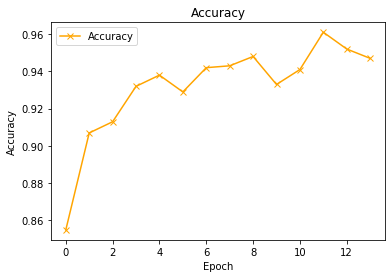

max_acc: 96.09609609609609%, epoch: 11, time: 461.848182s


In [10]:
if 1 in results_y:
    print("Maybe this model has over-fitted to your dataset. ")
print(results_x)
print(results_y)
plt.title("Accuracy")
plt.plot(results_x, results_y, marker = "x", color = "orange")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Accuracy"])
plt.show()
print("max_acc: {0}%, epoch: {1}, time: {2:.6f}s".format(max(results_y) * 100, results_y.index(max(results_y)), \
    ((endTime - startTime).total_seconds() - pauseTime * epochs) * (results_y.index(max(results_y)) + 1) / (epochs - 1)))
torch.save(model, modelpth) # save model

In [11]:
model = torch.load(modelpth) # load model

In [12]:
if torch.cuda.is_available():
    model = torch.load(modelpth)
else:
    model = torch.load(modelpth, map_location = 'cpu')
model.cpu()

Net(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (resnet_layer): Sequential(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [13]:
# verification
class_correct = list(0. for i in range(class_count))
class_total = list(0. for i in range(class_count))
with torch.no_grad():
    for data in validloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(c)):
            try:
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            except IndexError:
                pass
        if enhance_tmp:
            class_correct[label] = min(class_correct[label] * 2, class_total[label])
        #print(class_correct, class_total)

for i in range(class_count):
    if class_total[i] == 0:
        if sum(class_total) == 0:
            print("This model is not available on the questions you are trying to solve. ")
        else:
            print("Average maximum accuracy: {0}%".format(100 * sum(class_correct) / sum(class_total)))
        break
else: # naturally break
    for i in range(class_count):
        print("Accuracy of {0}: {1} / {2} = {3}%".format(classes[i], class_correct[i], class_total[i], 100 * class_correct[i] / class_total[i]))

Accuracy of 01_TUMOR: 59.0 / 61.0 = 96.72131147540983%
Accuracy of 02_STROMA: 56.0 / 59.0 = 94.91525423728814%
Accuracy of 03_COMPLEX: 53.0 / 62.0 = 85.48387096774194%
Accuracy of 04_LYMPHO: 65.0 / 65.0 = 100.0%
Accuracy of 05_DEBRIS: 56.0 / 59.0 = 94.91525423728814%
Accuracy of 06_MUCOSA: 71.0 / 73.0 = 97.26027397260275%
Accuracy of 07_ADIPOSE: 57.0 / 59.0 = 96.61016949152543%
Accuracy of 08_EMPTY: 65.0 / 65.0 = 100.0%
